### Notebook setup

In [1]:
%matplotlib inline
%autosave 30

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_rows', 10)
np.random.seed(42)

Autosaving every 30 seconds


### Datasets

| Dataset             | Comment                                           | Size (clicks/size)  |
|---------------------|---------------------------------------------------|---------------------|
| train.csv           | the training set                                  | 57.537.506 / 2.5 GB |
| train_sample.csv    | sample of training set                            | 100.000 / 3.9 MB |
| test.csv            | the test set                                      | 18.790.469 / 824 MB |
| test_supplement.csv | larger test set, subset used for Kaggle evaluation | 57.537.505 / 2.5GB  |


Every click record has following associated fields:
- click_time: timestamp of click (UTC)
- ip: ip address of click
- device: device type of user mobile phone
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- app: app id for marketing

Training data contains two additional fields:
- is_attributed: was app downloaded, to be predicted
- attributed_time: time of app download

For the given click data, the goal is to output the probability that the user will download the app.


Read train and test sets for local modeling and evaluation.

In [2]:
def read_dataset(path, nrows=None):
    """Reads dataset from CSV file, with optional number of rows"""
    
    df = pd.read_csv(path, nrows=nrows)
    df['click_time'] = pd.to_datetime(df['click_time'])
    df = df.set_index('click_time')
    df.sort_index(inplace=True)
    
    return df

# Training data set
dataset_train = read_dataset('data/mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv')

# Benchmark test set, same as used in benchmark model: https://rpubs.com/el16/410747
dataset_test = read_dataset('data/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv', nrows=1000000)

# Larger test set, used for Kaggle Leaderboard evaluation
dataset_test_all = read_dataset('data/test.csv')

### Data exploration

In [3]:
dataset_train.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [4]:
ser = dataset_train.nunique()
pd.DataFrame({'attribute':ser.index, 'unique values':ser.values})

,attribute,unique values
0,ip,34857
1,app,161
2,device,100
3,os,130
4,channel,161
5,attributed_time,227
6,is_attributed,2


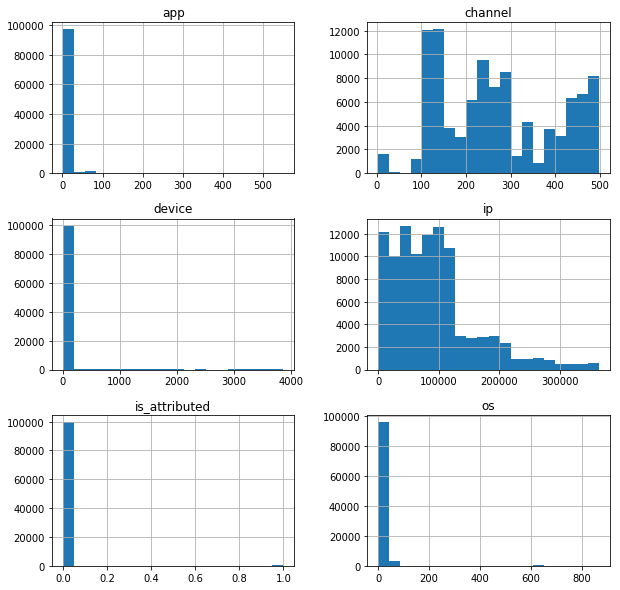

In [5]:
dataset_train.hist(bins=20, figsize=(10,10));

Distribution of `is_attributed` feature shows heavily unbalanced dataset towards no download cases.

In [6]:
corr = dataset_train.corr()
corr.style.background_gradient()

,ip,app,device,os,channel,is_attributed
ip,1,0.0103998,-0.00149891,-0.000469915,0.00756287,0.0549551
app,0.0103998,1,0.248376,0.24716,-0.0282377,0.064426
device,-0.00149891,0.248376,1,0.924456,-0.0353978,-0.000695177
os,-0.000469915,0.24716,0.924456,1,-0.0331755,0.00618346
channel,0.00756287,-0.0282377,-0.0353978,-0.0331755,1,-0.0233364
is_attributed,0.0549551,0.064426,-0.000695177,0.00618346,-0.0233364,1


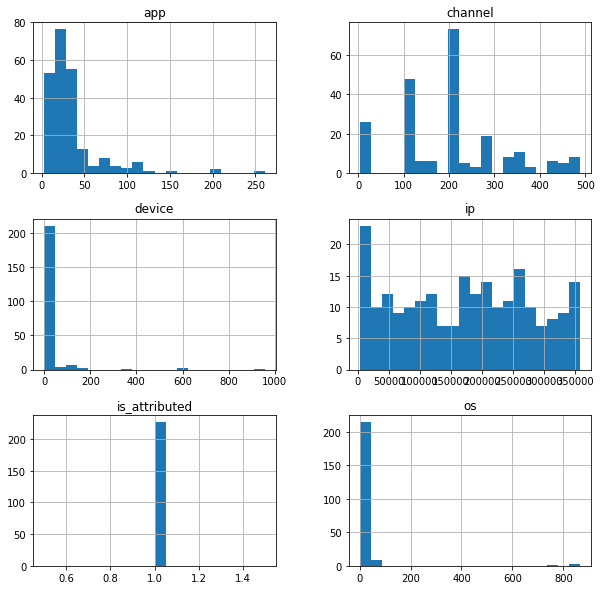

In [7]:
dataset_train[(dataset_train.is_attributed == 1)].hist(bins=20, figsize=(10,10));

In [8]:
top_apps = dataset_train.groupby(['ip'])['is_attributed'].agg(
    {"is_attributed": sum}).sort_values(
    "is_attributed", ascending=False).head(10).reset_index()
top_apps

/Users/dkomlen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,ip,is_attributed
0,5348,3
1,5314,3
2,171892,1
3,346097,1
4,29016,1
5,344369,1
6,265917,1
7,35308,1
8,344551,1
9,40654,1


In [9]:
top_apps = dataset_train.groupby(['app','channel'])['is_attributed'].agg(
    {"is_attributed": sum}).sort_values(
    "is_attributed", ascending=False).head(10).reset_index()
top_apps

/Users/dkomlen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,app,channel,is_attributed
0,19,213,50
1,10,113,17
2,29,213,16
3,35,21,15
4,5,113,13
5,35,274,12
6,19,347,11
7,72,101,6
8,19,282,5
9,45,5,5


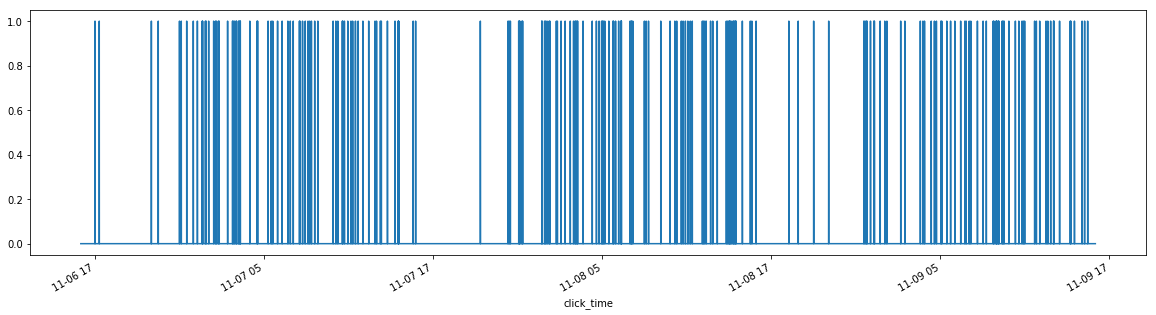

In [10]:
dataset_train.apply(lambda x: 1 if x['is_attributed'] == 1 else 0, axis=1).plot(figsize=(20, 5));

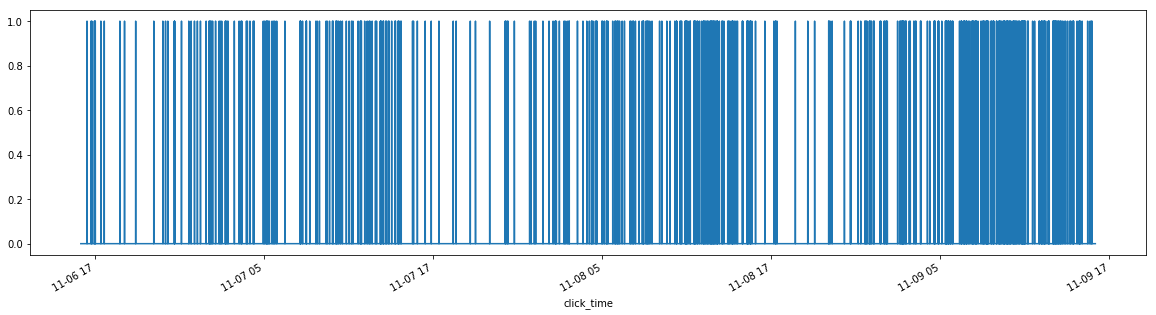

In [11]:
dataset_train.apply(lambda x: 1 if x['app'] == 19 else 0, axis=1).plot(figsize=(20, 5));

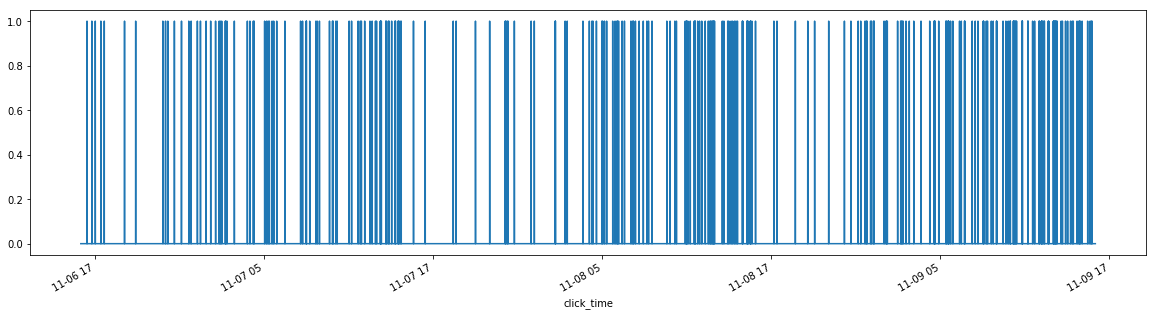

In [12]:
dataset_train.apply(lambda x: 1 if x['channel'] == 213 and x['app'] == 19 else 0, axis=1).plot(figsize=(20, 5));

### Benchmark models

For benchmark we will consider two models, one outputing constant value and second using random value from uniform distribution. Both will be evaluated on test set and the one with higher score will be used as baseline.

In [13]:
dataset_test.head()

,ip,app,device,os,channel,attributed_time,is_attributed
click_time,,,,,,,
2017-11-06 14:32:21,83230,3,1,13,379,NaN,0
2017-11-06 14:33:34,17357,3,1,19,379,NaN,0
2017-11-06 14:34:12,35810,3,1,13,379,NaN,0
2017-11-06 14:34:52,45745,14,1,13,478,NaN,0
2017-11-06 14:35:08,161007,3,1,13,379,NaN,0


In [14]:
benchmark_const = dataset_test_all[['click_id']].copy()
benchmark_const['is_attributed'] = 0
display(benchmark_const)

,click_id,is_attributed
click_time,,
2017-11-10 04:00:00,0,0
2017-11-10 04:00:00,1,0
2017-11-10 04:00:00,2,0
2017-11-10 04:00:00,3,0
2017-11-10 04:00:00,4,0
...,...,...
2017-11-10 15:00:00,18790464,0
2017-11-10 15:00:00,18790465,0
2017-11-10 15:00:00,18790467,0


In [15]:
benchmark_rand = dataset_test_all[['click_id']].copy()
benchmark_rand['is_attributed'] = np.random.uniform(size=len(benchmark_rand))
display(benchmark_rand)

,click_id,is_attributed
click_time,,
2017-11-10 04:00:00,0,0.374540
2017-11-10 04:00:00,1,0.950714
2017-11-10 04:00:00,2,0.731994
2017-11-10 04:00:00,3,0.598658
2017-11-10 04:00:00,4,0.156019
...,...,...
2017-11-10 15:00:00,18790464,0.099541
2017-11-10 15:00:00,18790465,0.038406
2017-11-10 15:00:00,18790467,0.016869


Constant model that predicts no app download scores 0.5 on Kaggle evaluator. Random model that uses uniform distribution scores 0.4995 as private score (82% of test data) and 0.5003 as public score (18% of the test data). One approach to this problem is done by [Elior Tal](https://rpubs.com/el16/410747) and his solution scores 0.825 on a subset of the test set. In his work he compares performance of random forest and boosting algorithms. We will use this as a benchmark model as it is well documented and scores better than our initial baseline models. Additionally we will use existing Kaggle solutions on the [leaderboard](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/leaderboard ) as a supporting benchmark.

### Data preprocessing

* Extract hour of the day
* For each attribute extract duration since last click with that attribute
* Remove attributes: attributed_time, click_time, is_attributed

In [16]:
from sklearn import preprocessing

def prepare_column(job):
    """Generate new features from target column"""
    
    df = job['df']
    col = job['feat']
    
    print ('Preparing column: ', col)
    def calculate_last(row, attr, attr_map):
        attr_val = row[attr]
        if attr_val in attr_map:
            st = attr_map.get(attr_val)
            et = row['click_time']
            val = min((et - st).total_seconds(), 86400)
        else:
            val = 86400
        attr_map[attr_val] = row['click_time']
        return val

    new_col = 'last_'+col
    df[new_col] = df.apply(calculate_last, axis=1, attr=col, attr_map={})
    x = df[[new_col]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df[new_col] = x_scaled
    return df[new_col]

def prepare_dataset(df):
    """Preprocess raw input dataset to enhanced dataset with additional features"""
    
    df['hour'] = df.index.hour
    df['click_time'] = df.index
    pool = mp.Pool(maxtasksperchild=1000)

    jobs = [{'df':df,'feat':feat} for feat in ['ip', 'app', 'os', 'channel', 'device']]
    with tqdm(total=len(jobs), desc="Preparing features") as pbar:
        for feat in pool.imap(prepare_column, jobs):
            df = pd.concat([df, feat], axis=1)
            pbar.update()
            
    pool.close()
    pool.join()

    return df.drop(labels=['is_attributed', 'attributed_time', 'click_time'], axis=1, errors='ignore')

In [17]:
print('Preparing train dataset')
train_y = dataset_train['is_attributed']
%time train_X = prepare_dataset(dataset_train)

print('Preparing test dataset')
test_y = dataset_test['is_attributed']
%time test_X = prepare_dataset(dataset_test)

Preparing train dataset


Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 508 ms, sys: 204 ms, total: 713 ms
Wall time: 20.7 s
Preparing test dataset


Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 2.54 s, sys: 2.63 s, total: 5.17 s
Wall time: 2min 58s


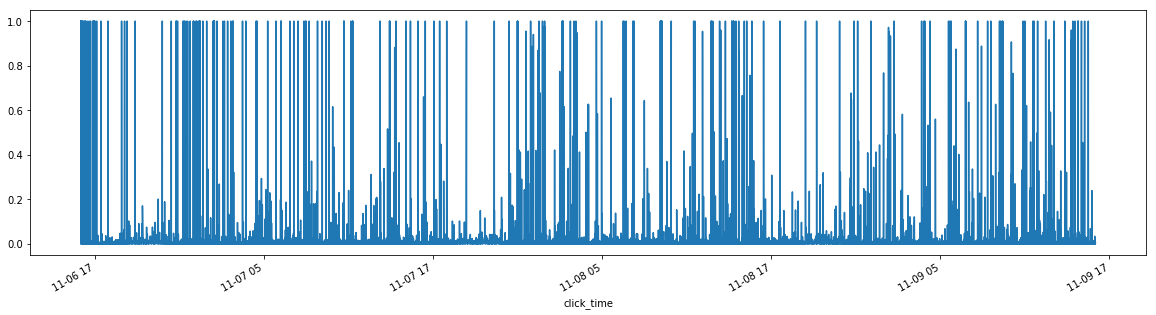

In [18]:
train_X['last_app'].plot(figsize=(20, 5));

In [19]:
train_X.tail()

,ip,app,device,os,channel,hour,last_ip,last_app,last_os,last_channel,last_device
click_time,,,,,,,,,,,
2017-11-09 15:59:42,85592,12,1,13,145,15,0.130498,0.000220,0.000035,0.000035,0.000012
2017-11-09 15:59:43,91779,18,1,41,379,15,1.000000,0.000104,0.001424,0.000556,0.000012
2017-11-09 15:59:44,81374,14,1,25,118,15,1.000000,0.000764,0.000613,0.007731,0.000012
2017-11-09 15:59:46,11911,1,1,22,115,15,1.000000,0.002373,0.000382,0.019086,0.000023
2017-11-09 15:59:51,44018,13,1,19,477,15,0.387813,0.002211,0.000336,0.001377,0.000058


Additional features to be considered adding:
- for each attribute number of clicks in previous N minutes with same attribute
value

### Model training

/Users/dkomlen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression confusion matrix:


,0,1
0,998306,1
1,1693,0


GaussianNB(priors=None)

GaussianNB confusion matrix:


,0,1
0,994224,4083
1,1482,211


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

DecisionTreeClassifier confusion matrix:


,0,1
0,996123,2184
1,1245,448


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier confusion matrix:


,0,1
0,998001,306
1,1572,121


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier confusion matrix:


,0,1
0,997829,478
1,1576,117


,auc,clf
0,0.564735,LogisticRegression
2,0.631216,DecisionTreeClassifier
4,0.736183,RandomForestClassifier
1,0.762397,GaussianNB
3,0.843181,GradientBoostingClassifier


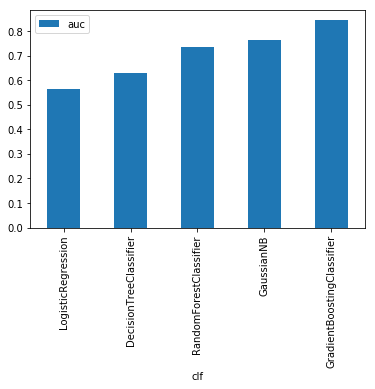

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

def evaluate_model(clf, tstX=test_X, tsty=test_y, verbose=True):
    """Evaluate model using AUC score on given test data"""
    
    predicted_proba_y = clf.predict_proba(tstX)[:,1]
    predicted_y = clf.predict(tstX)
    clf_name = str(clf).split('(')[0]
    if verbose:
        display(clf)
        print(clf_name + ' confusion matrix:')
        display(pd.DataFrame(confusion_matrix(tsty, predicted_y)))
    return [{'clf': clf_name,
            'auc': roc_auc_score(tsty, predicted_proba_y)}]

# Initial model evaluation using fixed random state
results = []
for clf in [LogisticRegression(random_state=42), 
            GaussianNB(), 
            tree.DecisionTreeClassifier(random_state=42),
            GradientBoostingClassifier(random_state=42),
            RandomForestClassifier(random_state=42)]:
    clf.fit(train_X, train_y)
    results += evaluate_model(clf)
    
results = pd.DataFrame(results).sort_values(by=['auc'])

display(results)
results.plot.bar(x='clf');

In [21]:
%%time

# https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.externals import joblib

def optimize_model(estimator, params, cv):
    scorer = make_scorer(roc_auc_score)
    gs = GridSearchCV(estimator=estimator, param_grid=params, 
                      scoring=scorer, cv=cv, verbose=3,
                      n_jobs=-1)
    return gs.fit(train_X, train_y)

cv = StratifiedKFold(n_splits=5, shuffle=True)
model = optimize_model(GradientBoostingClassifier(random_state=42), {
        'loss' : ['deviance', 'exponential'],
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [50, 100, 200],
    }, cv=cv)

joblib.dump(model, 'final_model.joblib') 
display(pd.DataFrame(evaluate_model(model)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=50, score=0.521638904927391, total=   8.2s
[CV] learning_rate=0.1, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=50, score=0.5758113363764121, total=   8.2s
[CV] learning_rate=0.1, loss=deviance, n_estimators=100 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=50, score=0.5886884378741056, total=   8.3s
[CV] learning_rate=0.1, loss=deviance, n_estimators=100 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=50, score=0.522071876426893, total=   8.4s
[CV] learning_rate=0.1, loss=deviance, n_estimators=100 

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min


[CV]  learning_rate=0.1, loss=exponential, n_estimators=100, score=0.5443692715467797, total=  17.9s
[CV] learning_rate=0.1, loss=exponential, n_estimators=200 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, score=0.5433529789853256, total=  35.0s
[CV] learning_rate=0.1, loss=exponential, n_estimators=200 ...........
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, score=0.6192394844922815, total=  35.4s
[CV] learning_rate=0.2, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, score=0.5888387761351931, total=  34.8s
[CV] learning_rate=0.2, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.2, loss=deviance, n_estimators=50, score=0.6184376804331484, total=   8.3s
[CV] learning_rate=0.2, loss=deviance, n_estimators=50 ...............
[CV]  learning_rate=0.1, loss=exponential, n_estimators=200, score=0.54431915628167, total=  35.0s
[CV] learning_rate=0.2, loss=deviance, n_esti

[CV] learning_rate=0.3, loss=exponential, n_estimators=50 ............
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.5541974878258691, total=   8.4s
[CV] learning_rate=0.3, loss=exponential, n_estimators=50 ............
[CV]  learning_rate=0.3, loss=deviance, n_estimators=200, score=0.6538766941743789, total=  31.7s
[CV] learning_rate=0.3, loss=exponential, n_estimators=50 ............
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.5649918839127166, total=   8.8s
[CV] learning_rate=0.3, loss=exponential, n_estimators=50 ............
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.5443943316907486, total=   8.8s
[CV] learning_rate=0.3, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.533208045170559, total=   8.6s
[CV] learning_rate=0.3, loss=exponential, n_estimators=100 ...........
[CV]  learning_rate=0.3, loss=exponential, n_estimators=50, score=0.555430267

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=3)

GridSearchCV confusion matrix:


,0,1
0,996623,1684
1,1322,371


,auc,clf
0,0.874531,GridSearchCV


CPU times: user 34 s, sys: 1.65 s, total: 35.7 s
Wall time: 7min 47s


In [22]:
model.estimator

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

### Sensitivity analysis

In [23]:
dataset_test_sens = dataset_test.copy()

time_delta = pd.Series([ pd.Timedelta(minutes=np.random.randint(-120, 121)) for i in range(len(test_X)) ])
dataset_test_sens.index = dataset_test_sens.index + time_delta
dataset_test_sens['click_time'] = dataset_test_sens.index
dataset_test_sens.sort_index(inplace=True)

In [24]:
display(dataset_test_sens.head())
display(dataset_test.head())

,ip,app,device,os,channel,attributed_time,is_attributed,hour,click_time
2017-11-06 12:36:21,83230,3,1,13,379,NaN,0,14,2017-11-06 12:36:21
2017-11-06 12:47:10,165970,3,1,13,379,NaN,0,14,2017-11-06 12:47:10
2017-11-06 12:48:07,47902,3,1,17,379,NaN,0,14,2017-11-06 12:48:07
2017-11-06 12:59:50,129614,3,1,19,379,NaN,0,14,2017-11-06 12:59:50
2017-11-06 13:04:39,38816,3,1,18,379,NaN,0,14,2017-11-06 13:04:39


,ip,app,device,os,channel,attributed_time,is_attributed,hour,click_time
click_time,,,,,,,,,
2017-11-06 14:32:21,83230,3,1,13,379,NaN,0,14,2017-11-06 14:32:21
2017-11-06 14:33:34,17357,3,1,19,379,NaN,0,14,2017-11-06 14:33:34
2017-11-06 14:34:12,35810,3,1,13,379,NaN,0,14,2017-11-06 14:34:12
2017-11-06 14:34:52,45745,14,1,13,478,NaN,0,14,2017-11-06 14:34:52
2017-11-06 14:35:08,161007,3,1,13,379,NaN,0,14,2017-11-06 14:35:08


In [25]:
print('Preparing modified test dataset')
test_sens_y = dataset_test_sens['is_attributed']
%time test_sens_X = prepare_dataset(dataset_test_sens)

test_sens_X.head()

Preparing modified test dataset


Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 2.21 s, sys: 2.46 s, total: 4.67 s
Wall time: 2min 41s


,ip,app,device,os,channel,hour,last_ip,last_app,last_os,last_channel,last_device
2017-11-06 12:36:21,83230,3,1,13,379,12,1.0,1.000000,1.000000,1.000000,1.000000
2017-11-06 12:47:10,165970,3,1,13,379,12,1.0,0.007512,0.007512,0.007512,0.007512
2017-11-06 12:48:07,47902,3,1,17,379,12,1.0,0.000660,1.000000,0.000660,0.000660
2017-11-06 12:59:50,129614,3,1,19,379,12,1.0,0.008137,1.000000,0.008137,0.008137
2017-11-06 13:04:39,38816,3,1,18,379,13,1.0,0.003345,1.000000,0.003345,0.003345


In [26]:
from sklearn.externals import joblib

model = joblib.load('final_model.joblib')

display(pd.DataFrame(evaluate_model(model, test_sens_X, test_sens_y)))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=3)

GridSearchCV confusion matrix:


,0,1
0,997653,654
1,1525,168


,auc,clf
0,0.867481,GridSearchCV


### Confidence intervals

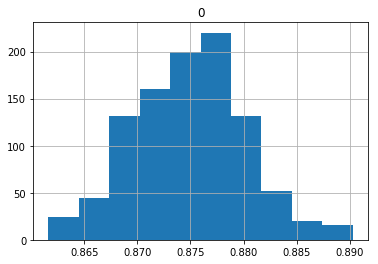

In [27]:
from sklearn.externals import joblib
from sklearn.utils import resample

n_bootstraps = 1000
bootstraps = []
model = joblib.load('final_model.joblib')

def bootstrap_score(i):
    sample_X, sample_y = resample(test_X, test_y)
    res = evaluate_model(model, sample_X, sample_y, False)
    return res[0]['auc']

with tqdm(total=n_bootstraps, desc="Preparing bootstraps") as pbar:
    pool = mp.Pool(maxtasksperchild=1000)

    for bootstrap in pool.imap(bootstrap_score, range(n_bootstraps)):
        bootstraps.append(bootstrap)
        pbar.update()
    pool.close()
    pool.join()
        
pd.DataFrame(bootstraps).hist();


In [28]:
alpha = 0.95
p = ((1.0 - alpha) / 2.0) * 100
lower = max(0.0, np.percentile(bootstraps, p))
p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(bootstraps, p))
print('%.1f confidence interval %.2f%% and %.2f%%' % (alpha*100, lower*100, upper*100))

95.0 confidence interval 86.50% and 88.55%


### Model evaluation

In [29]:
test_all_ids = dataset_test_all['click_id']
%time test_all_X = prepare_dataset(dataset_test_all.drop('click_id', axis=1))

Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 22.3 s, sys: 1min 15s, total: 1min 37s
Wall time: 1h 10min 49s


In [30]:
from sklearn.externals import joblib

clf = joblib.load('final_model.joblib') 
test_y = clf.predict_proba(test_all_X)

In [31]:
test_result = pd.DataFrame(test_y)

In [32]:
test_result = pd.DataFrame(test_y[:,1], columns=['is_attributed'])
test_result['click_id'] = test_all_ids.values

test_result.to_csv('data/test_result.csv.gz',compression='gzip', index=False)

Kaggle test results:
- private score: 0.8919713
- public score: 0.8888370